# Paso 1

## Función Load_Slices()

Implementar la función Load_Slices(): Permite la carga de los archivos DICOM que se encuentren en una carpeta

In [1]:
import pydicom as dcm
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import numpy as np
from skimage import transform, io,color
import matplotlib.pyplot as plt
import os
from matplotlib import cm


from skimage.filters import threshold_multiotsu

In [2]:
def Load_Slices(directorio):
    archivos=[]
    
    if directorio is None:
        print( "Directorio no seleccionado")
        return None
  
    for aname in Path(directorio).rglob("*.dcm"):
        print(f"Loading: {aname}")
        archivos.append(dcm.dcmread(aname))

    if not archivos:
        print(" Este directorio no tiene imagenes del formato seleccionado.")
        
    return archivos


In [3]:
directorio_imagenes=filedialog.askdirectory(title="Selecciona una carpeta")
print(directorio_imagenes)

C:/Users/albil/Desktop/SIS_INTELIGENTES/Práctica/Repositorios_GitHub/Practica1/DICOMs/DICOM_001


In [4]:
lista_datasets = Load_Slices(directorio_imagenes)

## Función CrearVolumen

#### Convertir a Hounsfield

In [5]:
def convertir_Hounsfield(lista_datasets):
        
    lista_H = [] 
    for ds in lista_datasets:
        b = ds.RescaleIntercept
        m = ds.RescaleSlope
        SV = ds.pixel_array

        ValorHounsfield = m*SV + b
        lista_H.append(ValorHounsfield)
    
    return lista_H

In [6]:
#Esta función nos informa del tipo de corte adquirido.
def OrientacionCorte (lista_datasets):
    #import numpy as np
    iop=lista_datasets.ImageOrientationPatient
    iop_rounded = [round(x) for x in iop]
    plane_cross = np.cross(iop_rounded[0:3], iop_rounded[3:6])
    plane = [abs(x) for x in plane_cross]
    if plane[0] == 1:
        return 'Sagital'
    elif plane[1] == 1:
        return 'Coronal'
    elif plane[2] == 1:
        return 'Axial'
    else:
        return 'NA'

In [7]:
def CrearVolumen(lista_datasets):
    if not lista_datasets:
        print("No hay imagenes DICOM.")
        return


    #Unicamente cargamos aquellos archivos DICOM que contengan el campo ImagePositionPatient en la lista denominada slices
    slices = []
    skipcount = 0
    for ds in lista_datasets:
        if hasattr(ds, "ImagePositionPatient"):
            slices.append(ds)
        else:
            skipcount = skipcount + 1

    print(f"Se han descartado {skipcount} archivos")

    if not slices:
        print("No se encontraron imágenes DICOM válidas con el atributo ImagePositionPatient.")
        return None

    
    # Ordenamos los cortes que se encuentran en la lista slices de acuerdo al campo ImagePositionPatient
    img_orient=OrientacionCorte (slices[0])
    if img_orient == 'Axial':
        slices = sorted(slices, key=lambda s: s.ImagePositionPatient[2])

    elif img_orient == 'Coronal':
        slices = sorted(slices, key=lambda s: s.ImagePositionPatient[1])

    elif img_orient == 'Sagital':
        slices = sorted(slices, key=lambda s: s.ImagePositionPatient[0])

    else:
        slices = []

    slices_H = convertir_Hounsfield(slices)
    
    ps = slices[0].PixelSpacing    #array bidimensional que contiene el tamaño de pixel en mm del corte.
    ss = slices[0].SliceThickness  #distancia en mm entre el corte almacenado del archivo y el inmediatamente anterior (o posterior)
    
    if img_orient == 'Axial':
        img_shape = list(slices[0].pixel_array.shape)
        img_shape.append(len(slices))
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices_H):
            img3d[:, :, len(slices)-i-1] = s
        ax_aspect = ps[0] / ps[1]
        sag_aspect = ss /ps[1]
        cor_aspect = ss /ps[0]
        voxel_size=[ps[0],ps[1],ss]
    
    elif img_orient =='Coronal':
        img_shape=[]
        img_shape.append(len(slices))
        img_shape.append(slices[0].pixel_array.shape[0])
        img_shape.append(slices[0].pixel_array.shape[1])
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices_H):
            img3d[i, :, :] = s.T
        ax_aspect = ss / ps[1]
        sag_aspect = ps[0] /ss
        cor_aspect = ps[0] / ps[1]
        voxel_size=[ps[0],ss, ps[1]]
    
    elif img_orient =='Sagital':
        img_shape=[]
        img_shape.append(slices[0].pixel_array.shape[0])
        img_shape.append(len(slices))    
        img_shape.append(slices[0].pixel_array.shape[1])
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices_H):
            img3d[:, len(slices)-i-1, :] = s.T
        ax_aspect = ps[0] /ss
        sag_aspect = ps[1] /ps[0] 
        cor_aspect = ps[1] /ss
        voxel_size=[ss, ps[0], ps[1]]
    else:
        print("Error en la obtención de la vista")

    
    relacion_aspecto = [ax_aspect, sag_aspect, cor_aspect]
    
    return img3d, img_shape, relacion_aspecto, voxel_size

In [8]:
lista_datasets = Load_Slices(directorio_imagenes)
CrearVolumen(lista_datasets)

Se han descartado 0 archivos


(array([[[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         ...,
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
        [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         ...,
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
        [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
         [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
      

## Función MetadataCT()

In [9]:
def MetadataCT(imagenes):

    if not imagenes:
        print("No hay imagenes DICOM.")
        return 
         
    imagen = imagenes[0]

    nombre_sujeto = imagen.get("PatientName", "Desconocido")
    edad_sujeto = imagen.get("PatientAge", "Desconocido")
    sexo_sujeto = imagen.get("PatientSex", "Desconocido")
    tipo_imagen = imagen.get("Modality", "Desconocido")
    fecha_adquisicion = imagen.get("AcquisitionDate", "Desconocido")
    modelo_tomografo = imagen.get("ManufacturerModelName", "Desconocido")
    tipo_adquisicion = imagen.get("SequenceName", "Desconocido")

    #Tamaño del vóxel
    ps = imagen.PixelSpacing
    ss = imagen.SliceThickness
    tamaño_voxel = (ps[1], ps[0], ss)  #(alto, ancho, espaciado)

    #Tamaño imagen
    alto = imagen.Rows
    ancho = imagen.Columns
    numero_imagenes=len(imagenes)
    tamaño_imagen_mm=(alto*ps[1], ancho*ps[0], numero_imagenes*ss)
    tamaño_imagen_voxeles=(alto, ancho, numero_imagenes)

    print(f"Nombre del sujeto: {nombre_sujeto}")
    print(f"Edad del sujeto: {edad_sujeto}")
    print(f"Sexo del sujeto: {sexo_sujeto}")
    print(f"Tipo de imagen: {tipo_imagen}")
    print(f"Fecha de adquisición: {fecha_adquisicion}")
    print(f"Modelo de tomógrafo en la que se realizó la prueba de imagen: {modelo_tomografo}")    
    print(f"Tipo de adquisición (corte): {tipo_adquisicion}")
    print(f"Tamaño del vóxel : {tamaño_voxel}")
    print(f"Tamaño de la imagen en mm: {tamaño_imagen_mm} mm")
    print(f"Tamaño de la imagen en voxeles: {tamaño_imagen_voxeles}")

    

In [10]:
imagenes_dicom = Load_Slices(directorio_imagenes)
#volumen, tamaño_voxel, relacion_aspecto, volumen_voxel = CrearVolumen(imagenes_dicom)
MetadataCT(imagenes_dicom)

Nombre del sujeto: A612161
Edad del sujeto: 036Y
Sexo del sujeto: M
Tipo de imagen: CT
Fecha de adquisición: 19001231
Modelo de tomógrafo en la que se realizó la prueba de imagen: Aquilion ONE
Tipo de adquisición (corte): Desconocido
Tamaño del vóxel : ('0.793', '0.793', '3.0')
Tamaño de la imagen en mm: (406.016, 406.016, 378.0) mm
Tamaño de la imagen en voxeles: (512, 512, 126)


## Función MuestraVolumen()

In [11]:
def MuestraVolumen(volumen, img_shape, relacion_aspecto, voxel_size, mostrar_histograma = False):
    #Calculamos el corte medio para cada orientación
    
    corte_medio_axial = volumen.shape[2] // 2
    corte_medio_coronal = volumen.shape[0] // 2
    corte_medio_sagital = volumen.shape[1] // 2
    
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize =(10, 10))
    ax = axes.ravel()
    
    #CORTE MEDIO AXIAL
    imagen_axial = volumen[:,:, corte_medio_axial]
    ax[2].imshow(imagen_axial, cmap=plt.cm.gray)
    ax[2].set_title(f"Corte axial:{corte_medio_axial}")
    ax[2].axis("off")
    ax[2].set_aspect(relacion_aspecto[0])
    #axial_aspect = relacion_aspecto[0]*voxel_size[0]
    #ax[0].set_aspect(axial_aspect)

    #CORTE MEDIO CORONAL
    imagen_coronal = volumen[corte_medio_coronal, :, :].T
    ax[0].imshow(imagen_coronal, cmap=plt.cm.gray)
    ax[0].set_title(f"Corte coronal:{corte_medio_coronal}")
    ax[0].axis("off")
    ax[0].set_aspect(relacion_aspecto[2])
    #coronal_aspect = relacion_aspecto[1]*voxel_size[1]
    #ax[1].set_aspect(coronal_aspect)

    #CORTE MEDIO SAGITAL
    imagen_sagital = volumen[:,corte_medio_sagital, :].T
    ax[1].imshow(imagen_sagital, cmap=plt.cm.gray)
    ax[1].set_title(f"Corte sagital:{corte_medio_sagital}")
    ax[1].axis("off")
    ax[1].set_aspect(relacion_aspecto[1])
    #sagital_aspect = relacion_aspecto[2]*voxel_size[2]
    #ax[2].set_aspect(sagital_aspect)

    #HISTOGRAMA
    if mostrar_histograma == True:
        histogram_256, bin_edges_256 = np.histogram(volumen, bins=256, range=(np.min(volumen),np.max(volumen)))
        ax[3].plot(bin_edges_256[0:-1], histogram_256)
        ax[3].set_title('Histograma en escala de grises de la imagen original')
        ax[3].set_xlabel("Unidades Hounsfield")
        ax[3].set_ylabel("Número de píxeles")
        ax[3].set_xlim([-2000.0, 1000.0]) 
        
    plt.tight_layout()
    plt.show()

Se han descartado 0 archivos


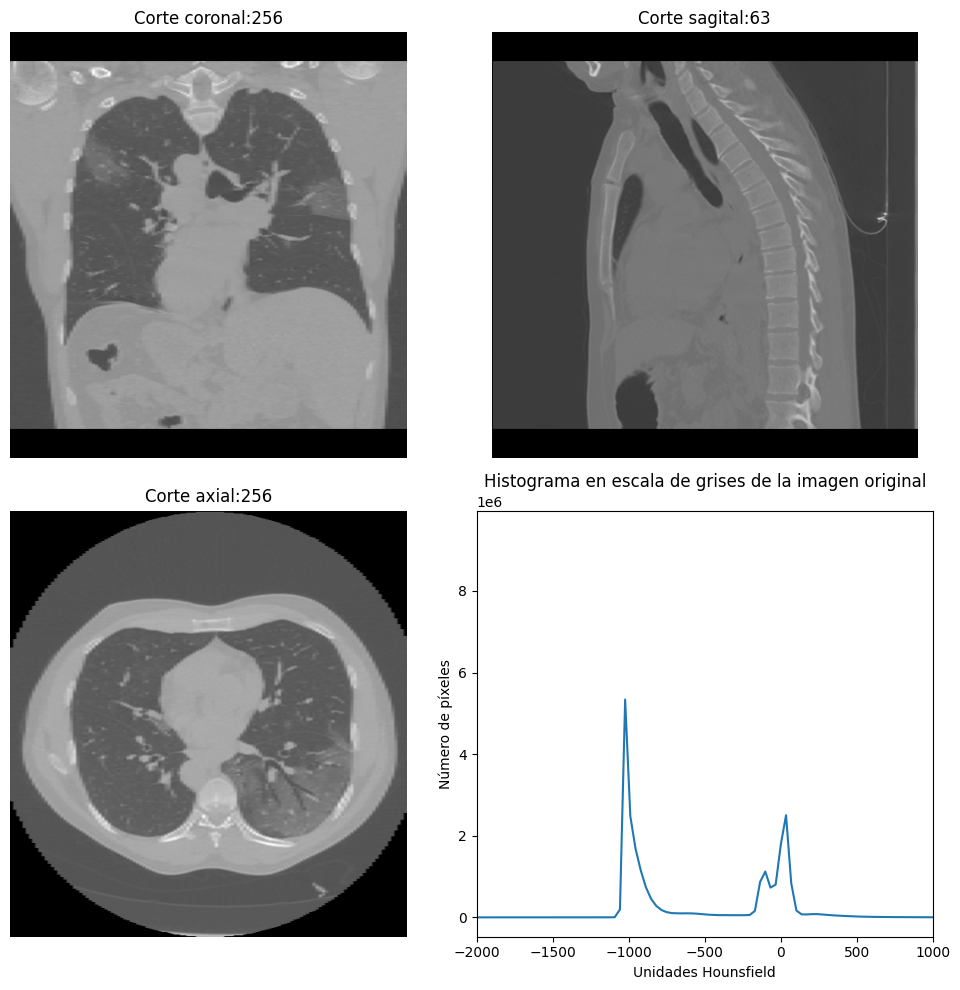

In [12]:
imagenes_dicom = Load_Slices(directorio_imagenes)
volumen, tamaño_voxel, relacion_aspecto, volumen_voxel = CrearVolumen(imagenes_dicom)
MuestraVolumen(volumen, tamaño_voxel, relacion_aspecto, volumen_voxel, mostrar_histograma = True)

# PASO 2

Se han descartado 0 archivos


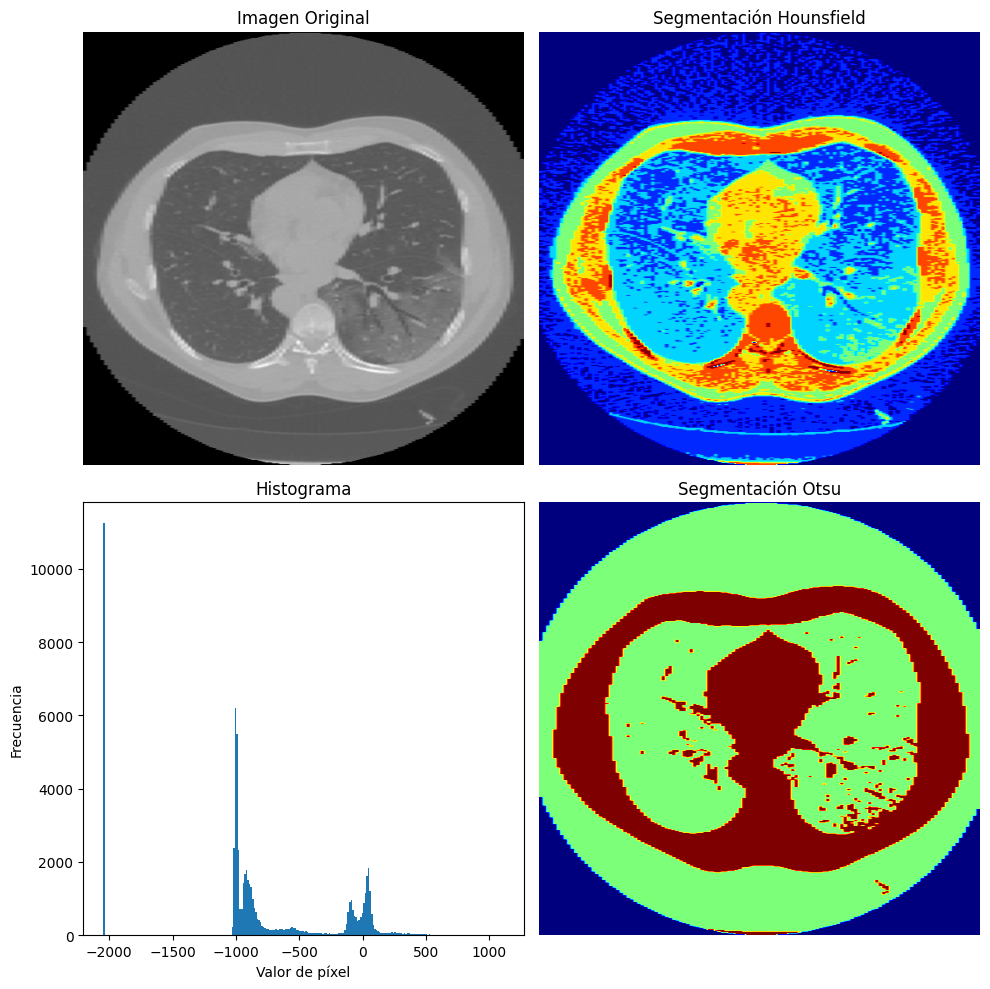

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters

def segmentacion_hounsfield(volumen):
    aire = (-1000, -900)
    pulmon = (-900, -500)
    tejido_adiposo = (-500, -50)
    agua = (-50, 50)
    tejido_blando = (50, 500)
    hueso = (500, 1000)

    mascara_aire = (volumen >= aire[0]) & (volumen < aire[1])
    mascara_pulmon = (volumen >= pulmon[0]) & (volumen < pulmon[1])
    mascara_tejido_adiposo = (volumen >= tejido_adiposo[0]) & (volumen < tejido_adiposo[1])
    mascara_agua = (volumen >= agua[0]) & (volumen < agua[1])
    mascara_tejido_blando = (volumen >= tejido_blando[0]) & (volumen < tejido_blando[1])
    mascara_hueso = (volumen >= hueso[0]) & (volumen <= hueso[1])

    segmentacion = np.zeros_like(volumen)
    segmentacion[mascara_aire] = 1
    segmentacion[mascara_pulmon] = 2
    segmentacion[mascara_tejido_adiposo] = 3
    segmentacion[mascara_agua] = 4
    segmentacion[mascara_tejido_blando] = 5
    segmentacion[mascara_hueso] = 6

    return segmentacion

def segmentacion_otsu(volumen):
    volumen_norm = (volumen - volumen.min()) / (volumen.max() - volumen.min())
    thresholds = filters.threshold_multiotsu(volumen_norm, classes=3)  # Cambia a 3 para pruebas
    segmentacion = np.digitize(volumen_norm, bins=thresholds)
    return segmentacion

def visualizar_segmentacion(volumen, segmentacion_hu, segmentacion_otsu):
    # Seleccionar un corte central para visualización
    corte = volumen.shape[2] // 2
   
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
   
    # Mostrar imagen original
    axs[0, 0].imshow(volumen[:, :, corte], cmap='gray',aspect='auto') #auto para asegurar que usamos la relacion aspecto correcta
    axs[0, 0].set_title('Imagen Original')
    axs[0, 0].axis('off')
   
    # Mostrar segmentación Hounsfield
    axs[0, 1].imshow(segmentacion_hu[:, :, corte], cmap='jet', aspect='auto')
    axs[0, 1].set_title('Segmentación Hounsfield')
    axs[0, 1].axis('off')
   
    # Mostrar histograma
    axs[1, 0].hist(volumen[:, :, corte].ravel(), bins=256)
    axs[1, 0].set_title('Histograma')
    axs[1, 0].set_xlabel('Valor de píxel')
    axs[1, 0].set_ylabel('Frecuencia')

    # Mostrar segmentación Otsu
    axs[1, 1].imshow(segmentacion_otsu[:, :, corte], cmap='jet', aspect='auto')  
    axs[1, 1].set_title('Segmentación Otsu')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Cargar el volumen (asegúrate de que esta parte se ajuste a tu código)
imagenes_dicom = Load_Slices(directorio_imagenes)
volumen, _, _, _ = CrearVolumen(imagenes_dicom)

# Realizar segmentación por Hounsfield
segmentacion_hu = segmentacion_hounsfield(volumen)

# Realizar segmentación por Otsu
segmentacion_otsu_result = segmentacion_otsu(volumen)

# Visualización de resultados
visualizar_segmentacion(volumen, segmentacion_hu, segmentacion_otsu_result)

#Guardamos las imágenes en los formatos estbalecidos (en nuestro caso, png)
def guardar_imagen(imagen, nombre):
    plt.imsave(f"{nombre}.png", imagen, cmap='jet', vmin=0, vmax=6)

# Guardar imágenes
corte = volumen.shape[2] // 2  # Seleccionar un corte central
guardar_imagen(volumen[:, :, corte], 'imagen_original')
guardar_imagen(segmentacion_hu[:, :, corte], 'segmentacion_hounsfield')
guardar_imagen(segmentacion_otsu_result[:, :, corte], 'segmentacion_otsu')
